In [1]:
import json
import pickle as pkl
import operator
import time
from collections import Counter
from itertools import product
import random

import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold

import psycopg2 as pg

from lightfm import LightFM
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import recall_at_k
from lightfm.evaluation import auc_score
from lightfm.evaluation import reciprocal_rank

%run '../lib/cookbook/recsys.py'
%run '../lib/cookbook/generic_preprocessing.py'
%run '../lib/utility.py'

import matplotlib.pyplot as plt
from IPython.display import HTML ## Setting display options for Ipython Notebook

## Reload Data

In [2]:
## No Free Games
user_top_games = pkl.load(open('../data/preprocessed_data/no_free_games/user_top_games.pkl', 'rb'))
user_top_games_filtered_hours = pkl.load(open('../data/preprocessed_data/no_free_games/user_top_games_filtered_hours.pkl', 'rb'))
user_top_games_filtered_percentile = pkl.load(open('../data/preprocessed_data/no_free_games/user_top_games_filtered_percentile.pkl', 'rb'))
games = pkl.load(open('../data/preprocessed_data/no_free_games/games.pkl', 'rb'))

## Train Test Split and Building Interaction Matrices

In [5]:
train_val, test = train_test_split(user_top_games_filtered_percentile, test_size=0.2, random_state=1337)

In [6]:
interactions_train_all = create_interaction_matrix(df = train_val,
                                                 user_col = 'user',
                                                 item_col = 'item',
                                                 rating_col = 'rating',
                                                 threshold = '1')

In [7]:
interactions_test = create_interaction_matrix(df = test,
                                         user_col = 'user',
                                         item_col = 'item',
                                         rating_col = 'rating',
                                         threshold = '1')

In [8]:
interactions_full = create_interaction_matrix(df = user_top_games_filtered_percentile,
                                                 user_col = 'user',
                                                 item_col = 'item',
                                                 rating_col = 'rating',
                                                 threshold = '1')

In [9]:
user_dict = create_user_dict(interactions=interactions_train_all)
games_dict = create_item_dict(df=games, id_col='item', name_col='item')

In [10]:
## create sparse matrices from interactions
sparse_train_all = sparse.csr_matrix(interactions_train_all.values)
sparse_test = sparse.csr_matrix(interactions_test.values)

# Analysis

# Train time by CPUs

In [15]:
model = LightFM(
                loss='warp',
                learning_schedule='adagrad',
                no_components=70,
                learning_rate=0.05,
                user_alpha=0.0001,
                item_alpha=0.0001,
                )

train_time = []

for i in range(1,20):
    time_start = time.time()
    model.fit(sparse_train_all,
              epochs=15,
              num_threads=i)
    time_end = time.time()
    train_time.append((i+1,time_end-time_start))

In [20]:
train_time

[(2, 58.676300048828125),
 (3, 44.74558997154236),
 (4, 39.82103085517883),
 (5, 34.751445055007935),
 (6, 31.818082809448242),
 (7, 29.778425931930542),
 (8, 26.036377429962158),
 (9, 24.70049476623535),
 (10, 23.526432991027832),
 (11, 22.85115957260132),
 (12, 22.83726167678833),
 (13, 21.021599769592285),
 (14, 20.588250875473022),
 (15, 19.809993267059326),
 (16, 18.98064136505127),
 (17, 18.279616594314575),
 (18, 16.767219066619873),
 (19, 17.012341499328613),
 (20, 16.279738187789917)]

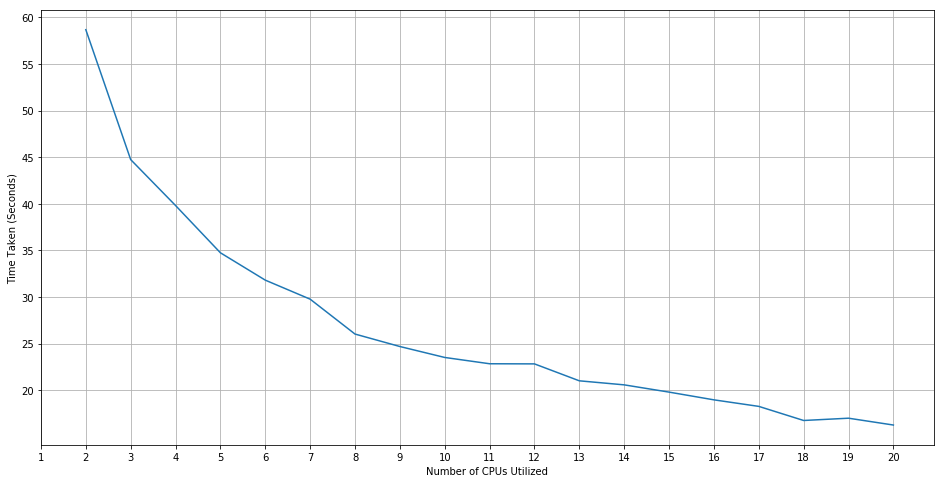

In [23]:
plt.clf()
X = [i[0] for i in train_time]
Y = [i[1] for i in train_time]
plt.plot(X, Y)
plt.rcParams["figure.figsize"] = [16,8]
plt.xticks([i for i in range(1,21)])
plt.yticks([20,25,30,35,40,45,50,55,60])
plt.xlabel('Number of CPUs Utilized')
plt.ylabel('Time Taken (Seconds)')
plt.grid()

# Epochs

In [18]:
model = LightFM(
                loss='warp',
                learning_schedule='adagrad',
                no_components=70,
                learning_rate=0.05,
                user_alpha=0.0001,
                item_alpha=0.0001,
                )

train_auc_epoch = []
test_auc_epoch = []

for i in range(100):
    model.fit_partial(sparse_train_all,
                    num_threads=10)
    train_auc = auc_score(model, sparse_train_all, num_threads=10).mean()
    test_auc = auc_score(model, sparse_test, sparse_train_all, num_threads=10).mean()
    train_auc_epoch.append((i+1,train_auc))
    test_auc_epoch.append((i+1,test_auc))

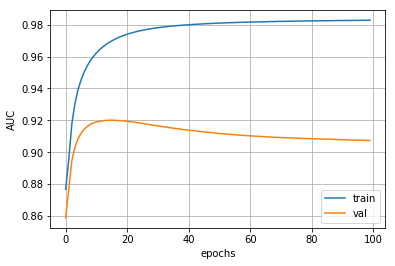

In [19]:
plt.clf()
plt.plot([i[1] for i in train_auc_epoch], label='train')
plt.plot([i[1] for i in test_auc_epoch], label='val')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid()

In [20]:
model = LightFM(
                loss='bpr',
                learning_schedule='adagrad',
                no_components=70,
                learning_rate=0.01,
                user_alpha=0.001,
                item_alpha=0.0001,
                )

train_auc_epoch = []
test_auc_epoch = []

for i in range(100):
    model.fit_partial(sparse_train_all,
                    num_threads=10)
    train_auc = auc_score(model, sparse_train_all, num_threads=10).mean()
    test_auc = auc_score(model, sparse_test, sparse_train_all, num_threads=10).mean()
    train_auc_epoch.append((i+1,train_auc))
    test_auc_epoch.append((i+1,test_auc))

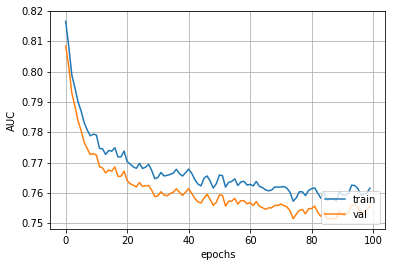

In [21]:
plt.clf()
plt.plot([i[1] for i in train_auc_epoch], label='train')
plt.plot([i[1] for i in test_auc_epoch], label='val')
plt.xlabel('epochs')
plt.ylabel('AUC')
plt.legend(loc='lower right')
plt.grid()

# Cold Start

In [11]:
sqlalchemy_conn = create_sqlalchemy_connection('sqlalchemy_conn_str.txt')
best_parameters = query_best_parameters('sqlalchemy_conn_str.txt')

In [12]:
model = LightFM(**best_parameters)
model.fit(sparse_train_all,
            epochs=15,
            num_threads=30)

In [13]:
def select_cold_start(user_games, threshold=3): 
    df = user_games.groupby('user')['rating'].sum()
    df = df.loc[df.values <= threshold]
    return df.index

In [14]:
def select_hot_start(user_games, threshold=40): 
    df = user_games.groupby('user')['rating'].sum()
    df = df.loc[df.values >= threshold]
    return df.index

In [15]:
cold_start_users = select_cold_start(train_val, 5)
interactions_test_cold_start = interactions_test.copy()
interactions_test_cold_start.loc[~interactions_test_cold_start.index.isin(cold_start_users), :] = 0

In [16]:
test_auc = auc_score(model, csr_matrix(interactions_test_cold_start), csr_matrix(interactions_train_all), num_threads=16).mean()
print('AUC: test %.3f.' % (test_auc))

AUC: test 0.929.


In [32]:
hot_start_users = select_hot_start(train_val, 30)
interactions_test_hot_start = interactions_test.copy()
interactions_test_hot_start.loc[~interactions_test_hot_start.index.isin(hot_start_users), :] = 0

In [33]:
test_auc = auc_score(model, csr_matrix(interactions_test_hot_start), csr_matrix(interactions_train_all), num_threads=16).mean()
print('AUC: test %.3f.' % (test_auc))

AUC: test 0.887.


In [34]:
interactions_full_cold_start = interactions_full.copy()
interactions_full_cold_start.loc[~interactions_full_cold_start.index.isin(cold_start_users), :] = 0
full_games_cold = interactions_full_cold_start.sum(axis=0)
cold_start_game_list = full_games_cold.loc[test_games_cold.values > 0].sort_values(ascending=False)

In [35]:
interactions_full_hot_start = interactions_full.copy()
interactions_full_hot_start.loc[~interactions_full_hot_start.index.isin(hot_start_users), :] = 0
full_games_hot = interactions_full_hot_start.sum(axis=0)
hot_start_game_list = full_games_hot.loc[full_games_hot.values > 0].sort_values(ascending=False)

### Plot Distribution

Text(0.5, 0, 'Sorted by Game Popularity')

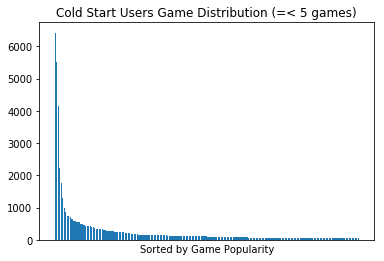

In [42]:
plt.bar(cold_start_game_list[:200].index,cold_start_game_list[:200].values)
plt.xticks([])
plt.title('Cold Start Users Game Distribution (=< 5 games)')
plt.xlabel('Sorted by Game Popularity')

Text(0.5, 0, 'Sorted by Game Popularity')

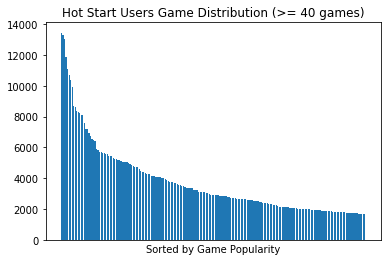

In [43]:
plt.bar(hot_start_game_list[:200].index,hot_start_game_list[:200].values)
plt.xticks([])
plt.title('Hot Start Users Game Distribution (>= 40 games)')
plt.xlabel('Sorted by Game Popularity')

### Plot Per User

In [21]:
def select_cold_start_exact(user_games, threshold=3): 
    df = user_games.groupby('user')['rating'].sum()
    df = df.loc[df.values == threshold]
    return df.index

In [ ]:
cold_start_values = []

for i in range(2,150):
    cold_start_users = select_cold_start_exact(train_val, i)
    interactions_test_cold_start = interactions_test.copy()
    interactions_test_cold_start.loc[~interactions_test_cold_start.index.isin(cold_start_users), :] = 0
    test_auc = auc_score(model, csr_matrix(interactions_test_cold_start), csr_matrix(interactions_train_all), num_threads=16).mean()
    cold_start_values.append((i,test_auc))
    print('AUC: test %.3f.' % (test_auc))

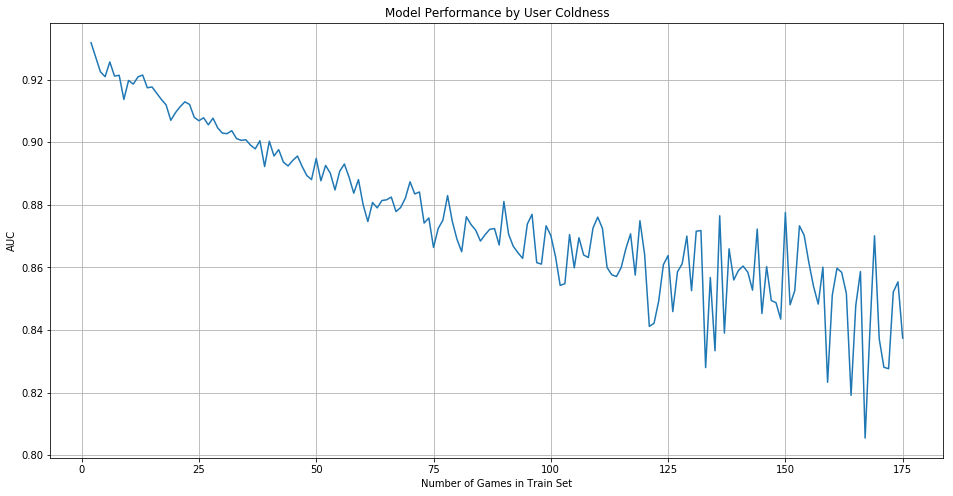

In [52]:
x = [i[0] for i in cold_start_values]
y = [i[1] for i in cold_start_values]
plt.plot(x, y)
plt.rcParams["figure.figsize"] = [16,8]
plt.xlabel('Number of Games in Train Set')
plt.ylabel('AUC')
plt.title('Model Performance by User Coldness')
plt.grid()

## Most Popular Games

In [1]:
def sort_popular_games(df):
    item_count_df = df.loc[df['rating'] == 1].groupby('item').count()
    return item_count_df.sort_values('rating', ascending=False)

In [2]:
def sort_user_owns(df):
    user_count_df = df.loc[df['rating'] == 1].groupby('user').count()
    return user_count_df.sort_values('rating', ascending=False)

In [68]:
popular_games = sort_popular_games(user_top_games)

In [70]:
user_owns = sort_user_owns(user_top_games)

In [71]:
user_owns

,item,rating
user,,
piepai,935,935
phrostb,935,935
chidvd,923,923
Steamified,857,857
DeEggMeister,849,849
76561197975369524,833,833
thugnificent,827,827
76561197983589335,793,793
proletar666,789,789
